# Purpose:
This notebook analyzes the combined AirBnb, Park, and Demographic data and attempts to isolate the effect of an AirBnB's proximity to a park on its rental price

The order of the notebook is:
- Prep
- EDA and Outliers
- Feature Creation
- Analysis

# Prep

In [483]:
# Packages

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import os
import zipfile

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import statsmodels.formula.api as smf

In [484]:
# Read in data
df = pd.read_csv('final.csv')
df.head()

,Unnamed: 0,Unnamed__0,id,listing_ur,name,interactio,host_since,host_is_su,host_ident,neighbourh,...,Basketball,Dogfriend,Eateries,Playground,Tennis,skate,parknum,area,park_name,geometry_y
0,0,348657,3185840,https://www.airbnb.com/rooms/3185840,Cozy Room in Lefferts Gardens!,We are both working professionals who travel q...,2014-05-21,f,t,Prospect-Lefferts Gardens,...,0,1,1,7,1,1,B073,2.523662,Prospect Park,POLYGON ((-73.96922134886606 40.67237187453492...
1,1,348780,3272610,https://www.airbnb.com/rooms/3272610,Beautiful 1BD on Prospect Park,NaN,2013-07-01,f,t,Prospect-Lefferts Gardens,...,0,1,1,7,1,1,B073,2.523662,Prospect Park,POLYGON ((-73.96922134886606 40.67237187453492...
2,2,349723,3857180,https://www.airbnb.com/rooms/3857180,Parkside Brooklyn Artist Apartment!,We want you to enjoy your stay so feel free to...,2012-10-14,f,f,Prospect-Lefferts Gardens,...,0,1,1,7,1,1,B073,2.523662,Prospect Park,POLYGON ((-73.96922134886606 40.67237187453492...
3,3,351448,4756551,https://www.airbnb.com/rooms/4756551,Bedroom w/Private Bath,I work from my home office and have a flexible...,2012-11-01,t,t,Prospect-Lefferts Gardens,...,0,1,1,7,1,1,B073,2.523662,Prospect Park,POLYGON ((-73.96922134886606 40.67237187453492...
4,4,351602,4810558,https://www.airbnb.com/rooms/4810558,Cozy apartment right on the park,NaN,2014-10-04,f,t,Prospect-Lefferts Gardens,...,0,1,1,7,1,1,B073,2.523662,Prospect Park,POLYGON ((-73.96922134886606 40.67237187453492...


### Remove columns

In [485]:
df.drop(['Unnamed: 0', 'geometry_x', 'geometry_y', 'total_po_1'], axis=1, inplace=True)

In [486]:
df.columns

Index(['Unnamed__0', 'id', 'listing_ur', 'name', 'interactio', 'host_since',
       'host_is_su', 'host_ident', 'neighbourh', 'market', 'latitude',
       'longitude', 'is_locatio', 'property_t', 'room_type', 'accommodat',
       'bedrooms', 'beds', 'bed_type', 'amenities', 'square_fee', 'price',
       'weekly_pri', 'monthly_pr', 'cleaning_f', 'guests_inc', 'extra_peop',
       'maximum_ni', 'review_sco', 'review_s_1', 'review_s_2', 'review_s_3',
       'review_s_4', 'review_s_5', 'review_s_6', 'instant_bo', 'reviews_pe',
       'price_clea', 'bedrooms_t', 'cleaning_1', 'Unnamed__1', 'census_tra',
       'total_popu', 'median_age', 'total_bach', 'median_inc', 'distance',
       'CTs', 'Selected N', 'Prop_ID', 'Barbecue', 'Basketball', 'Dogfriend',
       'Eateries', 'Playground', 'Tennis', 'skate', 'parknum', 'area',
       'park_name'],
      dtype='object')

### Fix Column names

In [487]:
df.columns = ['Unnamed__0', 'id', 'listing_url', 'name', 'interaction', 'host_since', 'host_is_superhost',
  'host_identity_verified', 'neighbourhood_cleansed',
 'market','latitude', 'longitude','is_location_exact','property_type', 'room_type', 
 'accommodates', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet',
'price', 'weekly_price', 'monthly_price', 'cleaning_fee','guests_included',
 'extra_people','maximum_nights', 'review_scores_rating', 'review_scores_accuracy',
'review_scores_cleanliness','review_scores_checkin', 'review_scores_communication',
 'review_scores_location', 'review_scores_value', 'instant_bookable', 'reviews_per_month', 'price_clean', 'bedrooms_to_beds', 
'cleaning_fee_clean', 'Unnamed__1', 'census_tract', 'total_population', 'median_age', 'percentage_bachelors_degree', 'median_income',
'distance', 'CTs', 'Selected N', 'Prop_ID','Barbecue', 'Basketball', 'Dogfriend', 'Eateries', 'Playground',
'Tennis', 'Skate', 'parknum', 'area', 'park_name']

In [488]:
df.drop(['cleaning_fee', 'price', 'CTs'], axis=1, inplace=True)

# Feature Creation

### distance_log

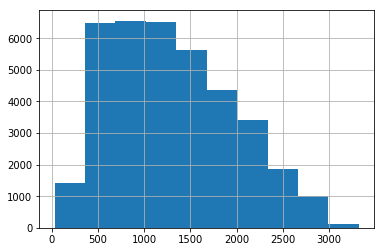

In [514]:
df.distance.hist()

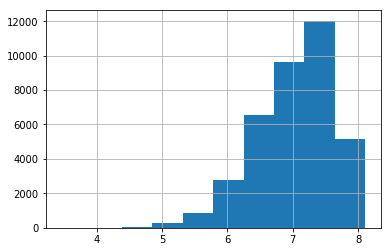

In [489]:
df['distance_log'] = np.log(df.distance)
df.distance_log.hist()

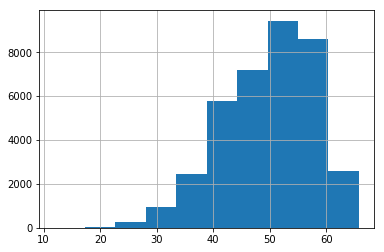

In [490]:
df['distance_log_sq'] = df.distance_log**2
df.distance_log_sq.hist()

### superhost binary

In [491]:
df.host_is_superhost.value_counts()

f    29776
t     7514
Name: host_is_superhost, dtype: int64

In [492]:
df['isSuperHost'] = df.host_is_superhost.apply(lambda x: 1 if (x=='t') else 0) 

### price_w_cleaning_fee

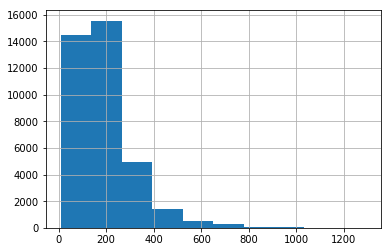

In [493]:
df['price_w_cleaning_fee'] = df.price_clean + df.cleaning_fee_clean
df.price_w_cleaning_fee.hist()

### isInstantBookable

In [494]:
df.instant_bookable.value_counts()

f    26918
t    10416
Name: instant_bookable, dtype: int64

In [495]:
df['isInstantBookable'] = df.instant_bookable.apply(lambda x: 1 if(x == 't') else 0)

### isActivePark

In [496]:
df['isActivePark'] = (df['Basketball'] > 0) | (df['Tennis'] > 0) | (df['Skate'] > 0)
df.isActivePark = df.isActivePark.apply(lambda x: 1 if(x) else 0)
df.isActivePark.value_counts()

1    32211
0     5123
Name: isActivePark, dtype: int64

In [497]:
# Which parks are passive
passive_df = df[df['isActivePark'] == 0]
passive_df.park_name.value_counts()

Washington Square Park    5123
Name: park_name, dtype: int64

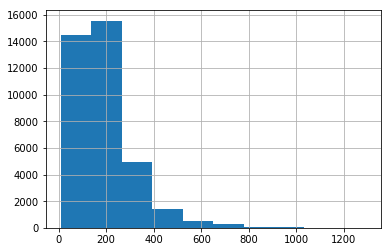

In [498]:
df.price_w_cleaning_fee.hist()

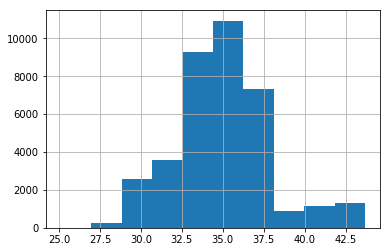

In [499]:
df.median_age.hist()

# EDA and Outliers

In [500]:
# make df with quantitative vars
quant = df[['isSuperHost','accommodates', 'bedrooms', 'beds', 'cleaning_fee_clean','guests_included',
         'maximum_nights', 'review_scores_rating', 'review_scores_accuracy',
        'review_scores_cleanliness','review_scores_checkin', 'review_scores_communication',
        'instant_bookable', 'reviews_per_month', 'price_clean',
         'total_population', 'median_age', 'percentage_bachelors_degree', 'median_income',
        'distance_log', 'distance_log_sq','Barbecue', 'Basketball', 'Eateries', 'Playground',
        'Tennis', 'Skate', 'area', 'price_w_cleaning_fee', 'isInstantBookable',
        'isActivePark']]

In [501]:
len(quant.columns)

31

### Correlation Plot

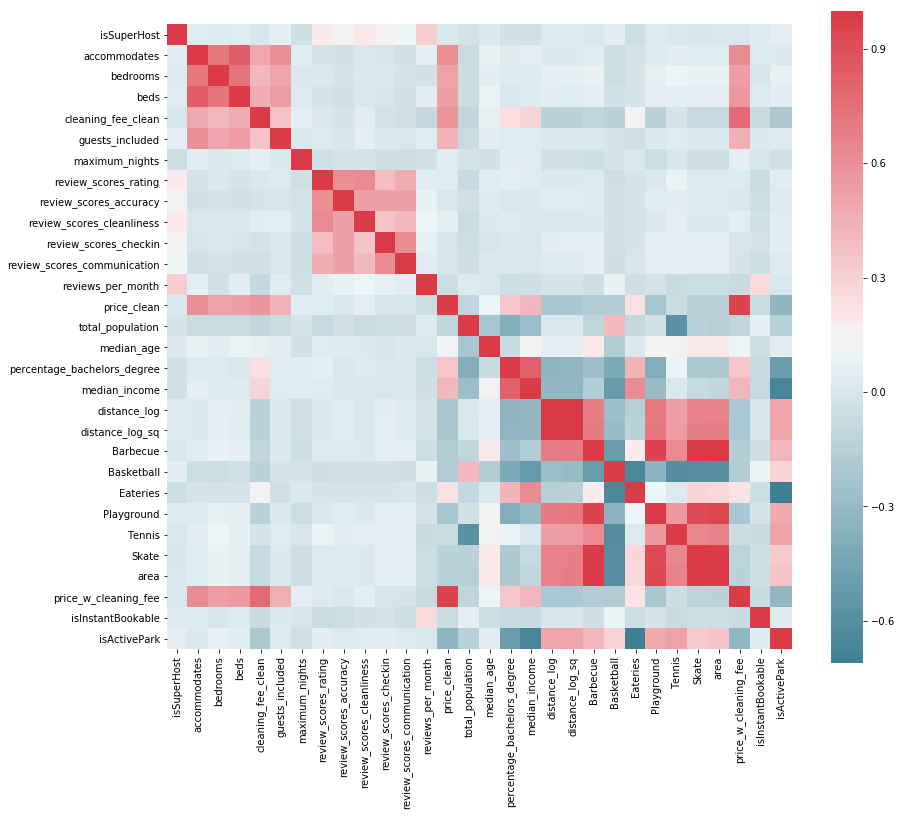

In [502]:
f, ax = plt.subplots(figsize=(14, 12))
corr = quant.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [515]:
for i in range(len(target_cols)):
    print('x' + str(i) + ': ' + target_cols[i])

x0: isSuperHost
x1: accommodates
x2: guests_included
x3: maximum_nights
x4: review_scores_rating
x5: reviews_per_month
x6: isInstantBookable
x7: total_population
x8: median_age
x9: median_income
x10: distance_log
x11: Eateries
x12: Playground
x13: isActivePark


### Collinearity notes:
- Choose one from 'accommodates', 'bedrooms', 'beds' (probably accommodates)
- Choose one from review_scores (probably review_scores_rating)
- Choose one from price_clean and price_w_cleaning_fee
- Choose isActivePark as proxy for Active amenities
- Choose area or amenities as they are highly collinear
- median_income and percentage_bachelors_degree highly correlated

In [545]:
df.to_csv('finalDataClean.csv')

# Analysis
1.) OLS

2.) Ridge

3.) Lasso

In [521]:
target_cols = [#AirBnB
        'isSuperHost','accommodates','guests_included',
         'maximum_nights', 'review_scores_rating', 'reviews_per_month', 'isInstantBookable',
        #Demographic
         'total_population', 'median_age', 'median_income',
        #Parks
        'distance_log', 'Eateries', 'Playground',
        'isActivePark'
        #Parkname for stratification
        #'park_name'
        ]
X = df[target_cols]
y_price_w_cleaning_fee = df['price_w_cleaning_fee']
y_price = df['price_clean']

### Standardize

In [522]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std =pd.DataFrame(scaler.fit_transform(X))
X = pd.concat([X_std,df.park_name], axis=1)
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,park_name
0,-0.501975,-1.166632,-0.560455,0.61607,-0.111643,-0.656408,-0.622055,0.402636,0.180902,-0.655202,0.496169,0.331372,1.127265,0.398805,Prospect Park
1,-0.501975,-0.557292,-0.560455,0.61607,-0.111643,-0.548746,-0.622055,0.402636,0.180902,-0.655202,0.318146,0.331372,1.127265,0.398805,Prospect Park
2,-0.501975,0.661389,2.134436,0.61607,-1.676822,-0.536080,-0.622055,0.402636,0.180902,-0.655202,0.492573,0.331372,1.127265,0.398805,Prospect Park
3,1.992133,-0.557292,0.337842,-0.58028,0.357911,1.040856,-0.622055,0.402636,0.180902,-0.655202,0.378243,0.331372,1.127265,0.398805,Prospect Park
4,-0.501975,-0.557292,-0.560455,0.61607,0.827465,-0.719739,-0.622055,0.402636,0.180902,-0.655202,0.318146,0.331372,1.127265,0.398805,Prospect Park


### Split for OLS (no alpha)

In [523]:
X_train_w, X_test_w, y_train_ols_w, y_test_ols_w = train_test_split(X, y_price_w_cleaning_fee, random_state = 42, test_size = 0.20, stratify=X['park_name'])
X_train, X_test, y_train_ols, y_test_ols = train_test_split(X, y_price, random_state = 42, test_size = 0.20, stratify=X['park_name'])

X_train_ols = X_train.drop(['park_name'], axis=1)
X_test_ols = X_test.drop(['park_name'], axis=1)
X_train_ols_w = X_train_w.drop(['park_name'], axis=1)
X_test_ols_w = X_test_w.drop(['park_name'], axis=1)

### Split for training alphas


In [526]:
#For price_clean
X_mod, X_alpha, y_mod, y_alpha = train_test_split(X, y_price, random_state=42, test_size=0.20, stratify=X['park_name'])
X_train, X_test, y_train_rl, y_test_rl = train_test_split(X_mod, y_mod, random_state = 42, test_size = 0.20)
X_alpha_train, X_alpha_test, y_alpha_train_rl, y_alpha_test_rl = train_test_split(X_alpha, y_alpha, random_state = 42, test_size = 0.20)

X_alpha_train_rl = X_alpha_train.drop('park_name', axis=1)

X_alpha_test_rl = X_alpha_test.drop('park_name', axis=1)

X_train_rl = X_train.drop(['park_name'], axis=1)

X_test_rl = X_test.drop(['park_name'], axis=1)

In [527]:
#For price_w_cleaning_fee
X_mod, X_alpha, y_mod, y_alpha = train_test_split(X, y_price_w_cleaning_fee, random_state=42, test_size=0.20, stratify=X['park_name'])
X_train, X_test, y_train_rl_w, y_test_rl_w = train_test_split(X_mod, y_mod, random_state = 42, test_size = 0.20)
X_alpha_train, X_alpha_test, y_alpha_train_rl_w, y_alpha_test_rl_w = train_test_split(X_alpha, y_alpha, random_state = 42, test_size = 0.20)

X_alpha_train_w = X_alpha_train.drop('park_name', axis=1)

X_alpha_test_w = X_alpha_test.drop('park_name', axis=1)

X_train_rl_w = X_train.drop(['park_name'], axis=1)

X_test_rl_w = X_test.drop(['park_name'], axis=1)

### OLS

In [435]:
reg = LinearRegression()
reg.fit(X_train_ols, y_train_ols)
print('Price Score: %0.3f' %reg.score(X_test_ols, y_test_ols))
reg_w = LinearRegression()
reg_w.fit(X_train_ols_w, y_train_ols_w)
print('Price_with_cleaning: %0.3f' %reg.score(X_test_ols_w, y_test_ols_w))

Price Score: 0.545
Price_with_cleaning: 0.306


In [524]:
data = pd.concat([y_price_w_cleaning_fee, X],axis=1)
data = data.drop('park_name', axis=1)
data.head()
cols = []
for i in range(len(data.columns) - 1):
    cols.append('x' + str(i))
cols.insert(0,'price_w_cleaning_fee')
data.columns = cols
data.head()
result = smf.ols(formula = 'price_w_cleaning_fee ~ ' + "+".join(str(data.columns[i]) for i in range(1,len(data.columns))), data = data).fit()
OLS_coef=result.params
print(result.summary())

                             OLS Regression Results                             
Dep. Variable:     price_w_cleaning_fee   R-squared:                       0.579
Model:                              OLS   Adj. R-squared:                  0.579
Method:                   Least Squares   F-statistic:                     3662.
Date:                  Wed, 12 Dec 2018   Prob (F-statistic):               0.00
Time:                          10:43:38   Log-Likelihood:            -2.1717e+05
No. Observations:                 37334   AIC:                         4.344e+05
Df Residuals:                     37319   BIC:                         4.345e+05
Df Model:                            14                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    193.2512      0.421

In [525]:
for i in range(len(target_cols)):
    print('x' + str(i) + ': ' + target_cols[i])

x0: isSuperHost
x1: accommodates
x2: guests_included
x3: maximum_nights
x4: review_scores_rating
x5: reviews_per_month
x6: isInstantBookable
x7: total_population
x8: median_age
x9: median_income
x10: distance_log
x11: Eateries
x12: Playground
x13: isActivePark


### Ridge

Max Score alpha = 192


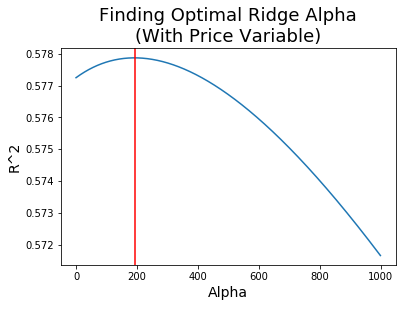

In [528]:
#For price dependent variable

# Find optimal alpha
alphas = np.arange(0,1000,1)
scores = []

for i in range(len(alphas)):
    ridge_alpha = Ridge(alpha=alphas[i])
    ridge_alpha.fit(X_alpha_train_rl, y_alpha_train_rl)
    scores.append(ridge_alpha.score(X_alpha_test_rl,y_alpha_test_rl))

max_alpha_ridge = str(alphas[scores.index(max(scores))])
print('Max Score alpha = ' + str(alphas[scores.index(max(scores))]))
plt.title('Finding Optimal Ridge Alpha\n(With Price Variable)',fontsize=18)
plt.xlabel('Alpha', fontsize=14)
plt.ylabel('R^2', fontsize=14)
plt.annotate('Alpha = %0.1f' %float(max_alpha_ridge), xy=(float(max_alpha_ridge)+1,0.6055), color='red', fontsize=14)
plt.plot(alphas, scores, '-')
plt.axvline(x=float(max_alpha_ridge),color='red')

Max Score alpha = 63


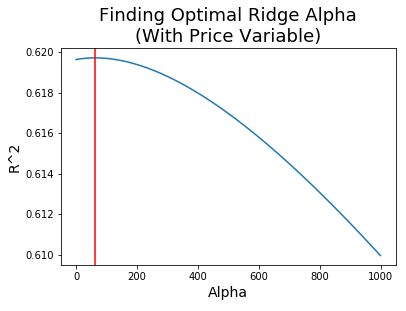

In [529]:
#For price with cleaning fee dependent variable

# Find optimal alpha
alphas = np.arange(0,1000,1)
scores = []

for i in range(len(alphas)):
    ridge_alpha = Ridge(alpha=alphas[i])
    ridge_alpha.fit(X_alpha_train_w, y_alpha_train_w)
    scores.append(ridge_alpha.score(X_alpha_test_w, y_alpha_test_w))

max_alpha_ridge_w = str(alphas[scores.index(max(scores))])
print('Max Score alpha = ' + str(alphas[scores.index(max(scores))]))
plt.title('Finding Optimal Ridge Alpha\n(With Price Variable)',fontsize=18)
plt.xlabel('Alpha', fontsize=14)
plt.ylabel('R^2', fontsize=14)
plt.annotate('Alpha = %0.1f' %float(max_alpha_ridge_w), xy=(float(max_alpha_ridge_w)+1,0.6055), color='red', fontsize=14)
plt.plot(alphas, scores, '-')
plt.axvline(x=float(max_alpha_ridge_w),color='red')

In [530]:
#Train and test
ridge = Ridge(alpha = max_alpha_ridge)
ridge.fit(X_train_rl, y_train_rl)
print("R^2 of Price Model: %f" %ridge.score(X_test_rl, y_test_rl))
      
ridge_w = Ridge(alpha = max_alpha_ridge_w)
ridge_w.fit(X_train_rl_w, y_train_rl_w)
print("R^2 of Price with Cleaning Fee Model: %f" %ridge_w.score(X_test_rl_w, y_test_rl_w))

R^2 of Price Model: 0.560313
R^2 of Price with Cleaning Fee Model: 0.584691


### Lasso

Max Score alpha = 0.226130653266


//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


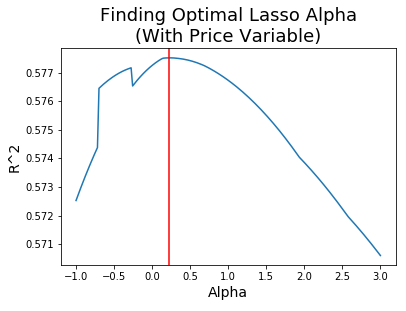

In [531]:
#For price dependent variable

# Find optimal alpha
#alphas = np.exp(np.linspace(-14,-2,200))
alphas = np.linspace(-1,3,200)

scores = []

for i in range(len(alphas)):
    lasso_alpha = Lasso(alpha=alphas[i])
    lasso_alpha.fit(X_alpha_train_rl, y_alpha_train_rl)
    scores.append(lasso_alpha.score(X_alpha_test_rl,y_alpha_test_rl))

max_alpha_lasso = str(alphas[scores.index(max(scores))])
print('Max Score alpha = ' + str(alphas[scores.index(max(scores))]))
plt.title('Finding Optimal Lasso Alpha\n(With Price Variable)',fontsize=18)
plt.xlabel('Alpha', fontsize=14)
plt.ylabel('R^2', fontsize=14)
plt.annotate('Alpha = %0.1f' %float(max_alpha_lasso), xy=(float(max_alpha_lasso)+1,0.60585), color='red', fontsize=14)
plt.plot(alphas, scores, '-')
plt.axvline(x=float(max_alpha_lasso),color='red')

Max Score alpha = 0.311557788945


//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


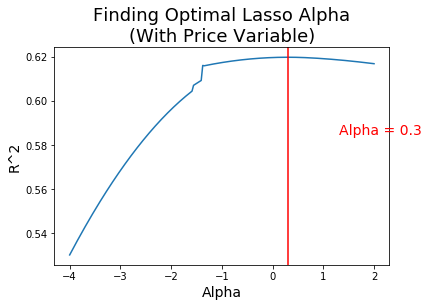

In [532]:
#For price with cleaning fee dependent variable

# Find optimal alpha
alphas = np.linspace(-4,2,200)
scores = []

for i in range(len(alphas)):
    lasso_alpha = Lasso(alpha=alphas[i])
    lasso_alpha.fit(X_alpha_train_w, y_alpha_train_w)
    scores.append(lasso_alpha.score(X_alpha_test_w, y_alpha_test_w))

max_alpha_lasso_w = str(alphas[scores.index(max(scores))])
print('Max Score alpha = ' + str(alphas[scores.index(max(scores))]))
plt.title('Finding Optimal Lasso Alpha\n(With Price Variable)',fontsize=18)
plt.xlabel('Alpha', fontsize=14)
plt.ylabel('R^2', fontsize=14)
plt.annotate('Alpha = %0.1f' %float(max_alpha_lasso_w), xy=(float(max_alpha_lasso_w)+1,0.58485), color='red', fontsize=14)
plt.plot(alphas, scores, '-')
plt.axvline(x=float(max_alpha_lasso_w),color='red')

In [534]:
#Train and Test
lasso = Lasso(alpha = float(max_alpha_lasso), max_iter=5000)
lasso.fit(X_train_rl, y_train_rl)
print('R^2 of Price Model: %f' %lasso.score(X_test_rl, y_test_rl))

lasso_w = Lasso(alpha = float(max_alpha_lasso_w), max_iter=5000)
lasso_w.fit(X_train_rl_w, y_train_rl_w)
print('R^2 of Price Model: %f' %lasso_w.score(X_test_rl_w, y_test_rl_w))

R^2 of Price Model: 0.560101
R^2 of Price Model: 0.584079


## OLS:
R^2 of Price with Cleaning Fee Model: 0.579

## Ridge:
R^2 of Price Model: 0.560

R^2 of Price with Cleaning Fee Model: 0.584

## Lasso:
R^2 of Price Model: 0.560

R^2 of Price with Cleaning Fee Model: 0.584


#### Comments:
The best performing models, in terms of R^2, are the Lasso and Ridge models with Cleaning Fees added to the price (varnames = lasso_w, ridge_w)

- For interpretation, use OLS
- For prediction, use Ridge (equal R^2 to Lasso but less computationally expensive)

In [540]:
coefs_ridge = pd.DataFrame.from_items([('var_name', target_cols), ('coefficient_value', ridge_w.coef_)])
coefs_ridge = coefs_ridge.sort_values(by='coefficient_value')
coefs_ridge

,var_name,coefficient_value
13,isActivePark,-16.849304
12,Playground,-11.256518
5,reviews_per_month,-10.590451
6,isInstantBookable,-5.538456
11,Eateries,-3.276168
10,distance_log,-2.242293
7,total_population,-1.151072
3,maximum_nights,1.021410
0,isSuperHost,2.461742
8,median_age,3.661267


Text(0.5,0,'Parameter')

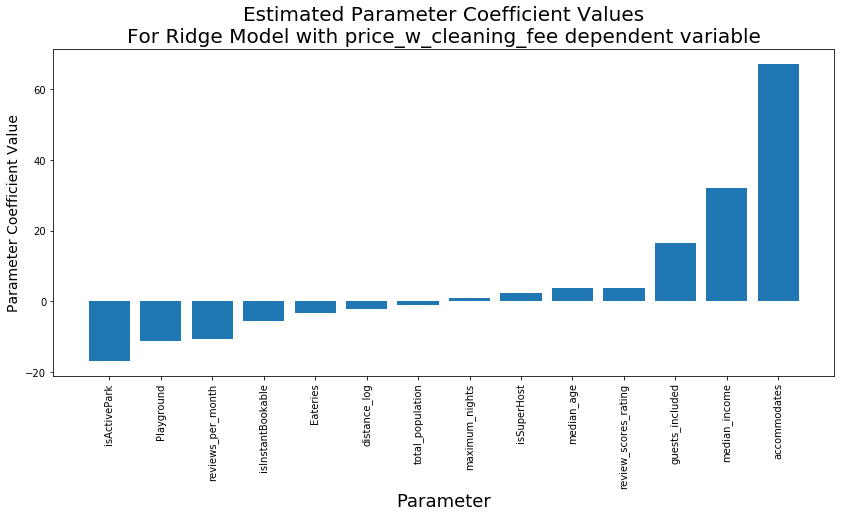

In [541]:
plt.figure(figsize=(14,6))
plt.bar(coefs_ridge.var_name, coefs_ridge.coefficient_value)
plt.xticks(rotation=90)
plt.title('Estimated Parameter Coefficient Values\nFor Ridge Model with price_w_cleaning_fee dependent variable',fontsize=20)
plt.ylabel('Parameter Coefficient Value', fontsize=14)
plt.xlabel('Parameter', fontsize=18)

In [542]:
coefs_lasso = pd.DataFrame.from_items([('var_name', target_cols), ('coefficient_value', lasso_w.coef_)])
coefs_lasso = coefs_lasso.sort_values(by='coefficient_value')
coefs_lasso

,var_name,coefficient_value
13,isActivePark,-13.951506
12,Playground,-12.933562
5,reviews_per_month,-10.239638
6,isInstantBookable,-5.374920
10,distance_log,-1.825555
11,Eateries,-0.550505
7,total_population,-0.303149
3,maximum_nights,0.711821
0,isSuperHost,2.079674
4,review_scores_rating,3.503610


Text(0.5,0,'Parameter')

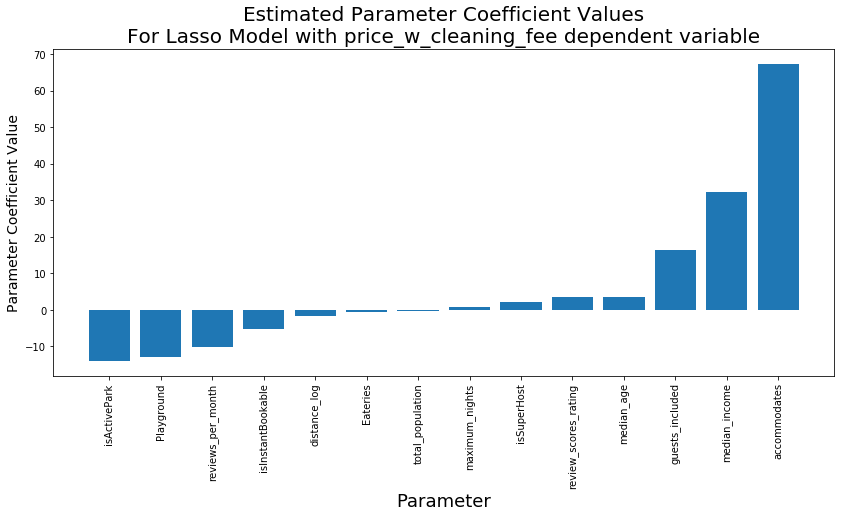

In [544]:
plt.figure(figsize=(14,6))
plt.bar(coefs_lasso.var_name, coefs_lasso.coefficient_value)
plt.xticks(rotation=90)
plt.title('Estimated Parameter Coefficient Values\nFor Lasso Model with price_w_cleaning_fee dependent variable',fontsize=20)
plt.ylabel('Parameter Coefficient Value', fontsize=14)
plt.xlabel('Parameter', fontsize=18)